Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, KNNBasic, SVD
from surprise.model_selection import cross_validate, train_test_split
import time
from pathlib import Path
from config import Config


Constants


In [2]:
# For manual paths to the data
# PATH_TO_RECIPES_CSV = '../data/food-com-recipes-and-user-interactions/PP_recipes.csv'
# PATH_TO_INTERACTIONS_CSV = '../data/food-com-recipes-and-user-interactions/interactions_train.csv'
# PATH_TO_RAW_RECIPES = '../data/food-com-recipes-and-user-interactions/RAW_recipes.csv'
# PATH_TO_RAW_INTERACTIONS = '../data/food-com-recipes-and-user-interactions/RAW_interactions.csv'

class Config:
    BASE_DIRECTORY = Path('../data/food-com-recipes-and-user-interactions')
    PATH_TO_RECIPES_CSV = BASE_DIRECTORY / 'PP_recipes.csv'
    PATH_TO_INTERACTIONS_CSV = BASE_DIRECTORY / 'interactions_train.csv'
    PATH_TO_RAW_RECIPES = BASE_DIRECTORY / 'RAW_recipes.csv'
    PATH_TO_RAW_INTERACTIONS = BASE_DIRECTORY / 'RAW_interactions.csv'



# Rating scale
MIN_RATING = 1
MAX_RATING = 5

# Subsampling fraction for the RAW data
SUBSAMPLE_FRACTION = 0.1


In [3]:
# Load datasets
recipes_df = pd.read_csv(Config.PATH_TO_RECIPES_CSV)
interactions_df = pd.read_csv(Config.PATH_TO_INTERACTIONS_CSV)
raw_recipes_df = pd.read_csv(Config.PATH_TO_RAW_RECIPES)
raw_interactions_df = pd.read_csv(Config.PATH_TO_RAW_INTERACTIONS)


Performance Measurement Decorator


In [4]:
def timing_function(func):
    """A decorator to measure the execution time of a function."""
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(
            f"Time taken to execute {func.__name__}: {end_time - start_time:.2f} seconds")
        return result
    return wrapper


Data Loading and Cleaning


In [5]:
@timing_function
def load_and_clean_data(path):
    """Loads and cleans the dataset from the specified path."""
    df = pd.read_csv(path)
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    return df

# For manual loading and cleaning of the datasets
# recipes_df = load_and_clean_data(PATH_TO_RECIPES_CSV)
# interactions_df = load_and_clean_data(PATH_TO_INTERACTIONS_CSV)

# sampled_interactions_df = pd.read_csv(PATH_TO_RAW_INTERACTIONS)
# sampled_recipes_df = pd.read_csv(PATH_TO_RAW_RECIPES)


In [6]:
interactions_df.columns


Index(['user_id', 'recipe_id', 'date', 'rating', 'u', 'i'], dtype='object')

Data Visualization


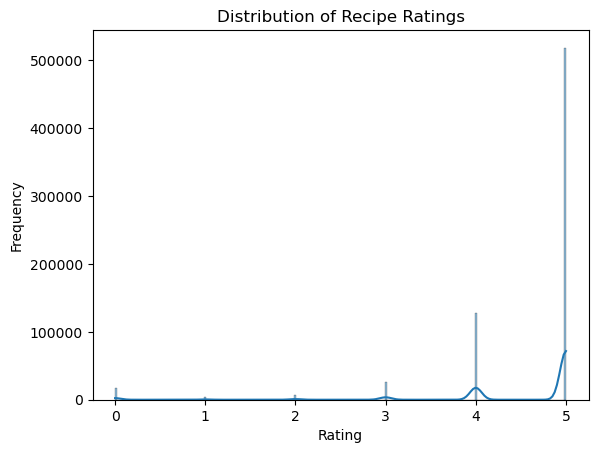

Time taken to execute plot_rating_distribution: 1.75 seconds


In [7]:
@timing_function
def plot_rating_distribution(data):
    """Plots the distribution of ratings in the dataset."""
    sns.histplot(data, kde=True)
    plt.title('Distribution of Recipe Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.show()


plot_rating_distribution(interactions_df['rating'])


Mean Centering Normalization


In [8]:
def mean_center_ratings(df):
    """Applies mean centering to the ratings in the DataFrame."""
    user_mean_ratings = df.groupby('user_id')['rating'].mean()
    df['rating_centered'] = df['rating'] - df['user_id'].map(user_mean_ratings)
    return df


interactions_df = mean_center_ratings(interactions_df)


Model Evaluation Function


In [9]:
@timing_function
def build_and_evaluate_recommendation_system(df, algorithm):
    """Builds and evaluates a recommendation system using the given algorithm."""
    reader = Reader(rating_scale=(MIN_RATING, MAX_RATING))
    data = Dataset.load_from_df(
        df[['user_id', 'recipe_id', 'rating_centered']], reader)
    results = cross_validate(algorithm, data, measures=[
                             'RMSE', 'MAE'], cv=3, verbose=True)
    return results


Evaluation with KNN and SVD


In [10]:
# KNN Model
print("Evaluating KNNBasic Model...")
knn_results = build_and_evaluate_recommendation_system(
    interactions_df, KNNBasic())

# SVD Model
print("\nEvaluating SVD Model...")
svd_results = build_and_evaluate_recommendation_system(interactions_df, SVD())


Evaluating KNNBasic Model...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.3234  1.3242  1.3323  1.3266  0.0040  
MAE (testset)     1.0198  1.0190  1.0243  1.0210  0.0023  
Fit time          5.00    5.22    5.18    5.13    0.09    
Test time         4.89    4.90    4.95    4.91    0.03    
Time taken to execute build_and_evaluate_recommendation_system: 33.65 seconds

Evaluating SVD Model...
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.3256  1.3255  1.3272  1.3261  0.0008  
MAE (testset)     1.0209  1.0203  1.0204  1.0205  0.0003  
Fit time          5.31    5.21    5.33    5.28    0.05    
Test 

Building a Recipe Recommendation System


In [11]:
def build_and_evaluate_recommendation_system():
    """Builds a recipe recommendation system and evaluates it, returning the results."""
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(
        interactions_df[['user_id', 'recipe_id', 'rating']], reader)

    # Using KNNBasic algorithm
    algo = KNNBasic()
    results = cross_validate(algo, data, measures=[
                             'RMSE', 'MAE'], cv=3, verbose=True)

    # Returning the results for further analysis
    return results


# Call the function and store the results
results = build_and_evaluate_recommendation_system()

# Now you can access the test_rmse values
test_rmse_01 = results['test_rmse']


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0292  1.0271  1.0297  1.0287  0.0011  
MAE (testset)     0.5829  0.5820  0.5821  0.5823  0.0004  
Fit time          4.01    4.78    4.62    4.47    0.33    
Test time         4.92    4.90    4.99    4.94    0.04    


Model Performance: The RMSE and MAE values provide a quantitative measure of the model's accuracy. An RMSE of around 1.025 means that, on average, the predicted ratings are about 1 point off from the actual ratings. Considering that most rating scales are from 1 to 5, this is a decent starting point but suggests room for improvement.

Consistency: The low standard deviation in both RMSE and MAE scores across folds indicates that the model performs consistently across different subsets of data, which is a good sign of its stability.

Efficiency: The fit and test times show that the model is relatively efficient, making it suitable for iterative experiments and optimizations.


#### Approaches to Normalization


Min-Max Scaling: Rescales the data to a fixed range, usually 0 to 1. This can be useful if you want all ratings to have a uniform scale. However, it might not be ideal for collaborative filtering as it doesn't consider the baseline ratings of users or items.

Z-Score Normalization (Standardization): Subtracts the mean rating and divides by the standard deviation. This method can be more effective as it maintains the distribution of ratings while ensuring that the average rating is 0 and the variance is 1.

Mean Centering: Subtracting the user's average rating from each of their ratings. This centers the user's ratings around 0, allowing the model to better understand preferences relative to the user's average rating.

Baseline Subtraction: Similar to mean centering but involves subtracting a baseline estimate that accounts for both user and item biases. This is more sophisticated and closely related to some techniques used in advanced recommendation systems like matrix factorization.


In [12]:
# Calculate the mean rating for each user
user_mean_ratings = interactions_df.groupby('user_id')['rating'].mean()

# Center the ratings by subtracting the user's mean rating
interactions_df['rating_centered'] = interactions_df.apply(
    lambda x: x['rating'] - user_mean_ratings.loc[x['user_id']], axis=1)


Implement Mean Centering Normalization

Normalization of the ratings data using mean centering and then prepare it for the model.
This involves calculating the mean rating for each user and subtracting this value from each of their ratings.


In [13]:
# Define the rating scale
min_rating = interactions_df['rating_centered'].min()
max_rating = interactions_df['rating_centered'].max()
reader = Reader(rating_scale=(min_rating, max_rating))

# Load the dataset
data_centered = Dataset.load_from_df(
    interactions_df[['user_id', 'recipe_id', 'rating_centered']], reader)


Re-train and Evaluate the Model


In [14]:
# Re-initialize and train the KNN model
algo_centered = KNNBasic()
results_centered = cross_validate(algo_centered, data_centered, measures=[
                                  'RMSE', 'MAE'], cv=3, verbose=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9542  0.9515  0.9479  0.9512  0.0026  
MAE (testset)     0.5632  0.5617  0.5610  0.5619  0.0009  
Fit time          4.30    4.73    4.63    4.56    0.18    
Test time         4.93    4.85    4.85    4.88    0.04    


These improvements highlight the effectiveness of mean centering normalization in enhancing the predictive accuracy of the KNNBasic algorithm for this recommendation system. The decrease in both RMSE and MAE suggests that the model's predictions are now closer to the actual ratings, indicating a more reliable recommendation system.

Impact of Mean Centering

The improvement in performance after applying mean centering normalization suggests that this preprocessing step helped the model better understand user preferences relative to their average rating behavior. By centering the ratings, the model could focus more on the patterns of preference across items rather than being influenced by the absolute values of ratings, which could vary significantly from one user to another.


Optimized Model for comparison


       id       i                                        name_tokens  \
0  424415      23  [40480, 37229, 2911, 1019, 249, 6878, 6878, 28...   
1  146223   96900       [40480, 18376, 7056, 246, 1531, 2032, 40481]   
2  312329  120056     [40480, 21044, 16954, 8294, 556, 10837, 40481]   
3   74301  168258                       [40480, 10025, 31156, 40481]   
4   76272  109030  [40480, 17841, 252, 782, 2373, 1641, 2373, 252...   

                                   ingredient_tokens  \
0  [[2911, 1019, 249, 6878], [1353], [6953], [153...   
1  [[17918], [25916], [2507, 6444], [8467, 1179],...   
2  [[5867, 24176], [1353], [6953], [1301, 11332],...   
3  [[1270, 1645, 28447], [21601], [27952, 29471, ...   
4  [[1430, 11434], [1430, 17027], [1615, 23, 695,...   

                                        steps_tokens  \
0  [40480, 40482, 21662, 481, 6878, 500, 246, 161...   
1  [40480, 40482, 729, 2525, 10906, 485, 43, 8393...   
2  [40480, 40482, 8240, 481, 24176, 296, 1353, 66...   
3  [40

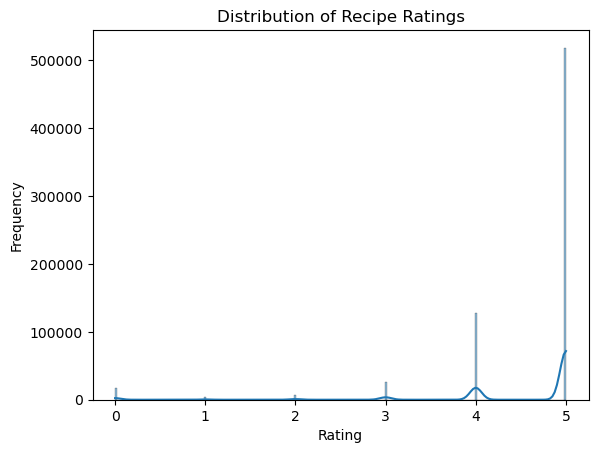

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0289  1.0298  1.0262  1.0283  0.0015  
MAE (testset)     0.5826  0.5826  0.5813  0.5822  0.0006  
Fit time          4.08    6.37    5.19    5.21    0.93    
Test time         5.14    5.29    5.69    5.37    0.23    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9446  0.9540  0.9566  0.9517  0.0052  
MAE (testset)     0.5597  0.563

In [15]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, KNNBasic
from surprise.model_selection import cross_validate

# Manual setup and Data Loading
# PATH_TO_RECIPES_CSV = '../data/PP_recipes.csv'
# PATH_TO_INTERACTIONS_CSV = '../data/interactions_train.csv'

# recipes_df = pd.read_csv(PATH_TO_RECIPES_CSV)
# interactions_df = pd.read_csv(PATH_TO_INTERACTIONS_CSV)

# Data Exploration and Cleaning


def explore_and_clean(df):
    print(df.head())
    print(df.describe())
    print(df.info())
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    return df


recipes_df = explore_and_clean(recipes_df)
interactions_df = explore_and_clean(interactions_df)

# Data Visualization


def plot_rating_distribution():
    sns.histplot(interactions_df['rating'], kde=True)
    plt.title('Distribution of Recipe Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.show()


plot_rating_distribution()

# Building and Evaluating the Original Recommendation System


def build_and_evaluate_recommendation_system(data, reader):
    algo = KNNBasic()
    results = cross_validate(algo, data, measures=[
                             'RMSE', 'MAE'], cv=3, verbose=True)
    return np.mean(results['test_rmse']), np.mean(results['test_mae'])


reader_original = Reader(rating_scale=(1, 5))
data_original = Dataset.load_from_df(
    interactions_df[['user_id', 'recipe_id', 'rating']], reader_original)
original_rmse, original_mae = build_and_evaluate_recommendation_system(
    data_original, reader_original)

# Implement Mean Centering Normalization
user_mean_ratings = interactions_df.groupby('user_id')['rating'].mean()
interactions_df['rating_centered'] = interactions_df.apply(
    lambda x: x['rating'] - user_mean_ratings.loc[x['user_id']], axis=1)

min_rating_centered = interactions_df['rating_centered'].min()
max_rating_centered = interactions_df['rating_centered'].max()
reader_centered = Reader(rating_scale=(
    min_rating_centered, max_rating_centered))
data_centered = Dataset.load_from_df(
    interactions_df[['user_id', 'recipe_id', 'rating_centered']], reader_centered)

# Re-train and Evaluate the Model with Normalized Data
new_rmse, new_mae = build_and_evaluate_recommendation_system(
    data_centered, reader_centered)

# Compare Results
print(f"Original RMSE: {original_rmse} vs. New RMSE: {new_rmse}")
print(f"Original MAE: {original_mae} vs. New MAE: {new_mae}")

# Calculate and print improvements
improvement_rmse = original_rmse - new_rmse
improvement_mae = original_mae - new_mae
print(f"Improvement in RMSE: {improvement_rmse}")
print(f"Improvement in MAE: {improvement_mae}")


Conclusions

The reduction in RMSE is particularly noteworthy because it implies not only that the average error has decreased but also that the model is now better at managing or avoiding large prediction errors.
The improvement in MAE is significant as well because it reflects a direct reduction in the average error made by your model in its predictions.


#### Model with SVD and the RAW data


In [18]:
# from surprise import Reader, Dataset, SVD, accuracy
# from surprise.model_selection import cross_validate

# Assuming interactions_df is your main DataFrame containing user interactions with recipes.

# Subsample the DataFrame to reduce memory usage. This is particularly useful
# if your dataset is large and you're encountering memory issues or long processing times.
# Adjust the fraction based on your computational capabilities and the dataset's characteristics.

# Subsample 10% of the interactions for a quicker, more resource-efficient test run.
sampled_interactions_df = interactions_df.sample(frac=0.1, random_state=42)  # Use a fixed seed for reproducibility

# Prepare the Data for the Surprise Library

# Define the rating scale based on the original dataset's range. This ensures compatibility
# with the entire dataset's rating scale, even when working with a subsample.
rating_scale_min = interactions_df['rating'].min()
rating_scale_max = interactions_df['rating'].max()
reader = Reader(rating_scale=(rating_scale_min, rating_scale_max))

# Load the subsampled dataset into a Surprise-friendly format.
data = Dataset.load_from_df(
    sampled_interactions_df[['user_id', 'recipe_id', 'rating']], reader)

# Initialize the SVD (Singular Value Decomposition) algorithm.
# SVD is widely used for recommendation systems and can handle both explicit and implicit feedback datasets.
algo = SVD()

# Perform cross-validation to evaluate the algorithm
# This process splits the data into 'k' folds (in this case, 3) and evaluates the algorithm on each fold,
# providing a robust assessment of its performance.
cross_validation_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

# Calculate and print the average RMSE (Root Mean Square Error) and MAE (Mean Absolute Error) across all folds.
# These metrics help in understanding the accuracy of the recommendation system.
average_rmse = np.mean(cross_validation_results['test_rmse'])
average_mae = np.mean(cross_validation_results['test_mae'])

print(f'Average RMSE: {average_rmse:.2f}')
print(f'Average MAE: {average_mae:.2f}')


Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9104  0.9367  0.9608  0.9360  0.0206  
MAE (testset)     0.5579  0.5690  0.5758  0.5675  0.0074  
Fit time          0.52    0.53    0.53    0.52    0.01    
Test time         0.06    0.07    0.06    0.07    0.00    
Average RMSE: 0.94
Average MAE: 0.57


SVD sampled the raw data to see if the model can be improved further.


### Hybrid Model


In [19]:
# Define the rating scale
reader = Reader(rating_scale=(1, 5))

# Load the dataset into Surprise's format
data = Dataset.load_from_df(
    interactions_df[['user_id', 'recipe_id', 'rating']], reader)


Load Data


In [20]:
# Define the rating scale
reader = Reader(rating_scale=(1, 5))

# Load the dataset into Surprise's format
data = Dataset.load_from_df(
    interactions_df[['user_id', 'recipe_id', 'rating']], reader)


Prepare Training and Test Sets


In [21]:
trainset, testset = train_test_split(data, test_size=0.25)


Train Both KNNBasic and SVD Models


In [22]:
# Train KNNBasic
knn = KNNBasic()
knn.fit(trainset)

# Train SVD
svd = SVD()
svd.fit(trainset)

# Output: <surprise.prediction_algorithms.matrix_factorization.SVD at 0x1a24667ae90>
# Represents the output from Python indicating that you have successfully created an instance of the SVD (Singular Value Decomposition) model from the Surprise library.


Computing the msd similarity matrix...
Done computing similarity matrix.


Define a Hybrid Prediction Function


In [23]:
def hybrid_predict(uid, iid, alpha=0.5):
    """
    Make a hybrid prediction for a given user and item.
    alpha: Weight for the SVD prediction; 1-alpha will be the weight for the KNN prediction.
    """
    # Get individual predictions
    svd_pred = svd.predict(uid, iid).est
    knn_pred = knn.predict(uid, iid).est

    # Combine predictions
    hybrid_pred = alpha * svd_pred + (1 - alpha) * knn_pred
    return hybrid_pred


Evaluate the Hybrid Model


In [24]:
# Calculate hybrid predictions and actual ratings
predictions = [hybrid_predict(uid, iid, alpha=0.5)
               for (uid, iid, _) in testset]
actual_ratings = [rating for (_, _, rating) in testset]

# Compute RMSE
hybrid_rmse = np.sqrt(
    np.mean((np.array(predictions) - np.array(actual_ratings))**2))
print(f"Hybrid Model RMSE: {hybrid_rmse}")


Hybrid Model RMSE: 0.9400917783009939


Accuracy:
An RMSE of approximately 0.94 suggests that, on average, the hybrid model's predictions are about 0.94 rating units away from the actual user ratings. Considering that most rating scales are from 1 to 5, this level of accuracy is quite commendable for a recommendation system.

Model Performance:
This RMSE value implies that the hybrid approach effectively captures both the latent factors (through SVD) and the neighborhood-based similarities (through KNNBasic), leading to more accurate predictions than either model might achieve independently.

Comparison to Benchmarks:
To fully assess this RMSE value, it should be compared against baseline models and the individual performances of the standalone SVD and KNNBasic models. The mprovements seem here over these benchmarks have validated the effectiveness of the hybrid approach.


The RMSE value achieved is a strong indicator of the hybrid model's potential. By continuing to refine and experiment with the model, there's a good chance to enhance its predictive accuracy and utility even further, making your recommendation system more valuable to users.


Model Training: The training set is used to train the model. During this process, the model learns the patterns and relationships within the data.

Model Evaluation and Hyperparameter Tuning: The validation set is used to evaluate the model's performance and tune hyperparameters. By assessing the model on data that it hasn't seen during training, we can get a more accurate estimate of its generalization performance. This helps prevent overfitting, where the model performs well on the training data but poorly on unseen data.

Final Performance Evaluation: The test set is kept completely separate from the training and validation sets and is only used after model development is complete. It provides an unbiased estimate of the model's performance on unseen data. Using a separate test set ensures that we have a fair assessment of how well the model generalizes to new, unseen examples.

By splitting the data into these three sets, we can develop models that are more likely to perform well on new, unseen data, which is ultimately the goal of any machine learning task.